### Imports

In [1]:
# some imports we will need in this example

import numpy as np
import mudata as md
import anndata as ad
import scanpy as sc
import os

import multiDGD

# make sure we are in the correct directory
def switch_to_project_dir(name):
    cwd = os.getcwd()
    dir_hierarchy = cwd.split('/')
    index = dir_hierarchy.index(name)
    if index != len(dir_hierarchy) - 1:
        os.chdir('/'.join(dir_hierarchy[:index+1]))
        print('Moved to project directory: ', os.getcwd())

switch_to_project_dir('multiDGD')

/opt/anaconda3/envs/omics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Moved to project directory:  /Users/vschuste/Documents/work_KU/projects/multiDGD


### Load a pre-trained model

First we need to get the data the model was trained on. This will be removed for easier use in a future version.

In [2]:
from multiDGD.utils.model_loading import *

In [3]:
# get the data
data_dir = 'data/'
if not os.path.exists(os.path.join(data_dir, 'human_bonemarrow.h5ad')):
    print('Downloading data...')
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    os.chdir(data_dir)
    get_figshare_file('/articles/23796198/files/41740251', 'human_bonemarrow.h5ad.zip', f_zip=True)
    os.chdir('..')

# load the data
data = ad.read_h5ad(os.path.join(data_dir, 'human_bonemarrow.h5ad'))

# remove the test set from the data
data_train = data[data.obs['train_val_test'] == 'train']
data_test = data[data.obs['train_val_test'] == 'test']

In [4]:
# download the model file
model_dir = 'models/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(os.path.join(model_dir, 'dgd_human_bonemarrow.pt')):
    os.chdir(model_dir)
    get_figshare_file('/articles/23796198/files/41735907', 'dgd_human_bonemarrow.pt')
    # download the hyperparameters file
    get_figshare_file('/articles/23796198/files/41735904', 'dgd_human_bonemarrow_hyperparameters.json')
    os.chdir('..')

# load model from the saved checkpoint
model = multiDGD.DGD.load(data=data_train, save_dir='./models/', model_name='dgd_human_bonemarrow')

Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


## Integrating new data

### 1. Data with the same features

See the paper for results.

In [5]:
# predict the test set
model.predict_new(data_test)

making potential reps
   all potential reps:  torch.Size([88, 22])
calculating losses for each new sample and potential reps
training selected reps for  20  epochs


Training: 100%|██████████| 20/20 [24:33<00:00, 73.66s/epochs, loss=0.13, reconstruction_loss=0.126]


/opt/anaconda3/envs/omics/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/opt/anaconda3/envs/omics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


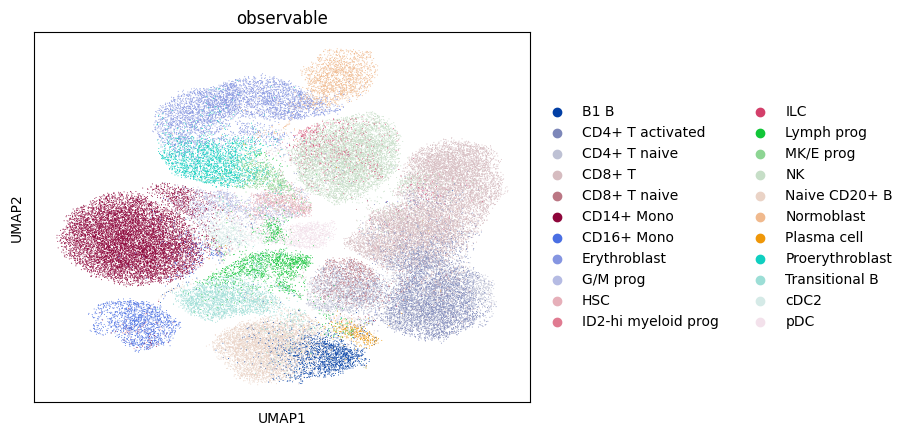

/opt/anaconda3/envs/omics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


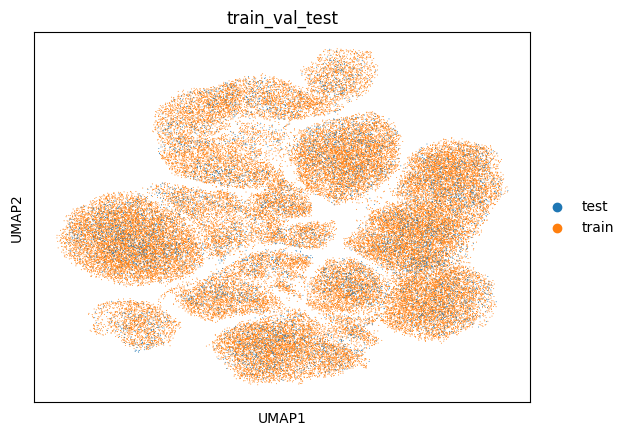

In [6]:
data_train.obsm['latent'] = model.get_representation(split='train')
data_test.obsm['latent'] = model.get_representation(split='test')
data_eval = data_train.concatenate(data_test)

sc.pp.neighbors(adata=data_eval, use_rep='latent', n_neighbors=10)
sc.tl.umap(data_eval, min_dist=1.0)
sc.pl.umap(data_eval, color='observable')
sc.pl.umap(data_eval, color='train_val_test')

### 2. Data with only one modality

In [7]:
data_test = data_test[:, data_test.var["modality"] == "ATAC"]

In [ ]:
# predict the test set
model.predict_new(data_test, n_epochs=20)

/Users/dbm829/anaconda3/envs/multiDGD_test/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/dbm829/anaconda3/envs/multiDGD_test/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/dbm829/anaconda3/envs/multiDGD_test/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDe

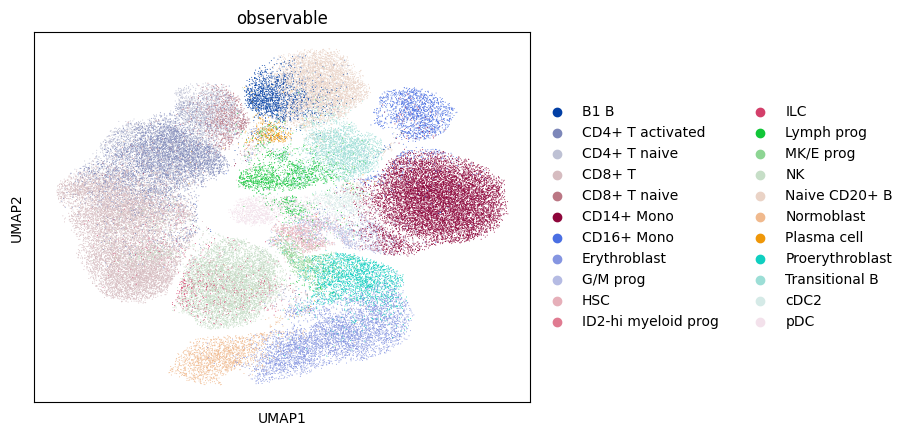

/Users/dbm829/anaconda3/envs/multiDGD_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


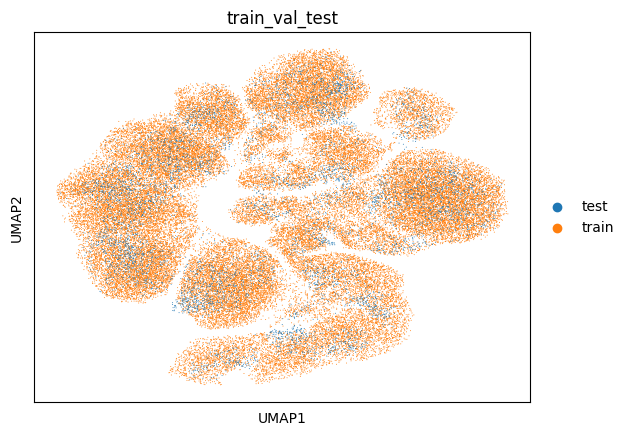

In [7]:
data_train.obsm['latent'] = model.get_representation(split='train')
data_test.obsm['latent'] = model.get_representation(split='test')
data_eval = data_train.concatenate(data_test)

sc.pp.neighbors(adata=data_eval, use_rep='latent', n_neighbors=10)
sc.tl.umap(data_eval, min_dist=1.0)
sc.pl.umap(data_eval, color='observable')
sc.pl.umap(data_eval, color='train_val_test')